In [2]:
import brickschema
from brickschema.namespaces import BRICK, RDFS, OWL, TAG, RDF, SH
from rdflib import URIRef
from utils import *
from relationship_relaxation import *
from type_relaxation_rdf import *
import networkx
brick_graph = brickschema.Graph(load_brick=True)

In [ ]:
brick_graph = brickschema.Graph(load_brick=True)

query = """SELECT ?afs ?afsp ?vav WHERE  {
    ?afs    a       brick:Air_Flow_Sensor .
    ?afsp   a       brick:Air_Flow_Setpoint .
    ?afs    brick:isPointOf ?vav .
    ?afsp   brick:isPointOf ?vav .
    ?vav    a   brick:VAV
}"""

query = """SELECT ?afs ?afsp ?vav WHERE  {
    ?afsp   a       brick:Air_Flow_Sensor .
    ?afsp   a       brick:Water_Flow_Sensor
}"""

extract_triples(query)

In [3]:
def create_ordered_list(triples_copy):
    ordered_list = []
    for item in triples_copy:
        for item_i in item:
            item_new = item_i.split('#')[-1]
            ordered_list.append(item_new)
    ordered_list.sort()
    return ordered_list
                
def relax_triples(G, triples, rules, rule_names, level_itr, node_idx, k_node):
    
    for r_index in range(len(rules)):
        rule = rules[r_index]
    
        for i in range(len(triples)):
            triple = triples[i]
            relaxed_triples = rule(triple)
        
            if len(relaxed_triples) > 0:
                for relaxed_triple in relaxed_triples:
                    triples_copy = triples.copy()
                    triples_copy[i] = relaxed_triple
                    
                    #Checking to see if it exists within graph
                    ordered_list = create_ordered_list(triples_copy)
                    
                    if any(G.nodes.data()[node]['ordered_id'] == ordered_list for node in G) == False:
                        G.add_node(node_idx, query=triples_copy, ordered_id = ordered_list)
                        G.add_edge(k_node, node_idx, rule=rule_names[r_index], level=level_itr, triple=i)
                        node_idx+=1
                        #print('node pass')
                    else:
                        #print('node deleted')
                        pass
                        
    return G, node_idx

def relaxtion_graph(query, limit):
    
    rules = [ApplyRule_LowerClass, ApplyRule_SiblingClass, ApplyRule_UpperClass, apply_rule_variable_relationship]
    rule_names = ['lower', 'sibling', 'upper', 'relationship']

    triples = extract_triples(query)

    G = networkx.Graph()
    node_idx = 1
    ordered_list = create_ordered_list(triples)
    G.add_node(node_idx, query=triples, ordered_id = ordered_list)
    node_idx+=1
    G_old = G.copy()
        
    # Create First Layer
    start_node = node_idx
    level_itr = 1
    G_new, node_idx = relax_triples(G, triples, rules, rule_names, level_itr, node_idx, k_node=1)
    end_node = node_idx
    G_new = G.copy()

    while len(G_old) < len(G_new):
        level_itr += 1
        print(level_itr)
        for k_node in range(start_node, end_node+1):
            query = G.nodes.data()[k_node]['query']
            triples = query.copy()
            G_old = G_new.copy()
            G_new, node_idx = relax_triples(G, triples, rules, rule_names, level_itr, node_idx, k_node)
        start_node = end_node+1
        end_node = node_idx
        if level_itr > limit:
            break

    return G_new

In [4]:
query = """SELECT ?afs ?afsp ?vav WHERE  {
    ?afsp   a       brick:Air_Flow_Sensor 
}"""

G_relaxed = relaxtion_graph(query, limit =10)

2
3


In [113]:
G_relaxed.edges.data()

EdgeDataView([(1, 2, {'rule': 'lower', 'level': 1, 'triple': 0}), (1, 3, {'rule': 'lower', 'level': 1, 'triple': 0}), (1, 4, {'rule': 'lower', 'level': 1, 'triple': 0}), (1, 5, {'rule': 'lower', 'level': 1, 'triple': 0}), (1, 6, {'rule': 'lower', 'level': 1, 'triple': 0}), (1, 7, {'rule': 'lower', 'level': 1, 'triple': 0}), (1, 8, {'rule': 'lower', 'level': 1, 'triple': 0}), (1, 9, {'rule': 'sibling', 'level': 1, 'triple': 0}), (1, 10, {'rule': 'sibling', 'level': 1, 'triple': 0}), (1, 11, {'rule': 'upper', 'level': 1, 'triple': 0}), (1, 12, {'rule': 'relationship', 'level': 1, 'triple': 0}), (1, 13, {'rule': 'relationship', 'level': 1, 'triple': 0}), (1, 14, {'rule': 'relationship', 'level': 1, 'triple': 0}), (1, 15, {'rule': 'relationship', 'level': 1, 'triple': 0}), (1, 16, {'rule': 'relationship', 'level': 1, 'triple': 0}), (1, 17, {'rule': 'relationship', 'level': 1, 'triple': 0}), (1, 18, {'rule': 'relationship', 'level': 1, 'triple': 0}), (1, 19, {'rule': 'relationship', 'level'

In [114]:
G_relaxed.nodes.data()

NodeDataView({1: {'query': [['?afsp', 'a', 'brick:Air_Flow_Sensor']], 'ordered_id': ['?afsp', 'a', 'brick:Air_Flow_Sensor']}, 2: {'query': [['?afsp', 'a', rdflib.term.URIRef('https://brickschema.org/schema/Brick#Exhaust_Air_Flow_Sensor')]], 'ordered_id': ['?afsp', 'Exhaust_Air_Flow_Sensor', 'a']}, 3: {'query': [['?afsp', 'a', rdflib.term.URIRef('https://brickschema.org/schema/Brick#Discharge_Air_Flow_Sensor')]], 'ordered_id': ['?afsp', 'Discharge_Air_Flow_Sensor', 'a']}, 4: {'query': [['?afsp', 'a', rdflib.term.URIRef('https://brickschema.org/schema/Brick#Bypass_Air_Flow_Sensor')]], 'ordered_id': ['?afsp', 'Bypass_Air_Flow_Sensor', 'a']}, 5: {'query': [['?afsp', 'a', rdflib.term.URIRef('https://brickschema.org/schema/Brick#Fume_Hood_Air_Flow_Sensor')]], 'ordered_id': ['?afsp', 'Fume_Hood_Air_Flow_Sensor', 'a']}, 6: {'query': [['?afsp', 'a', rdflib.term.URIRef('https://brickschema.org/schema/Brick#Supply_Air_Flow_Sensor')]], 'ordered_id': ['?afsp', 'Supply_Air_Flow_Sensor', 'a']}, 7: {'

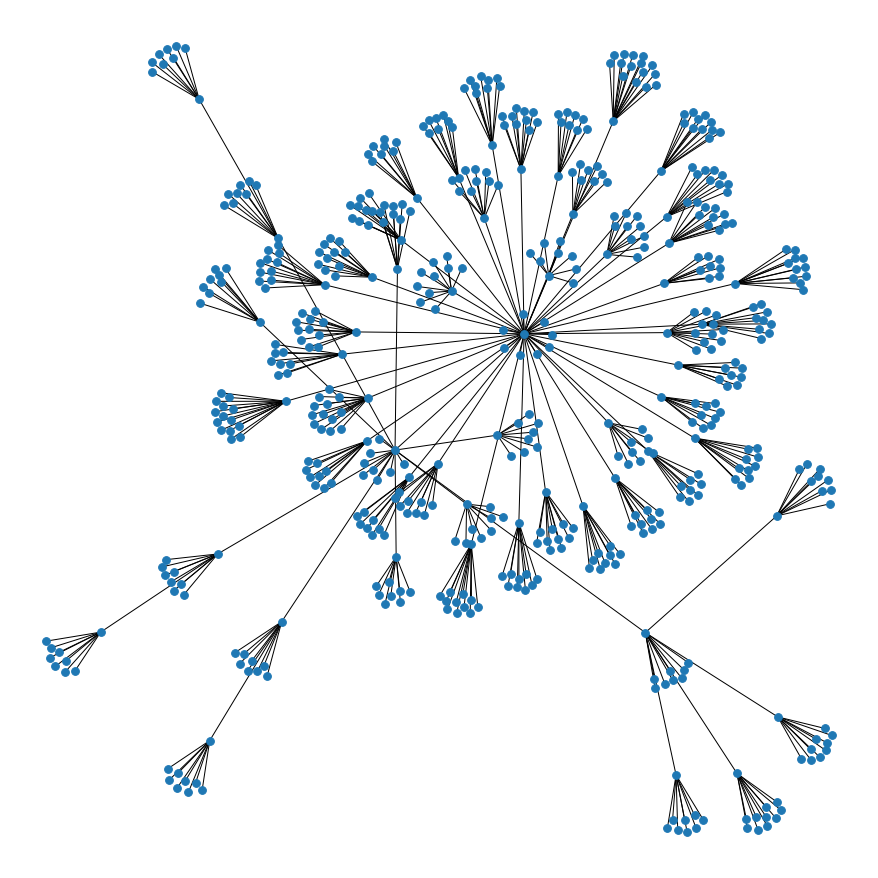

In [15]:
# Not ideal visual just validation
import matplotlib.pyplot as plt
import networkx as nx


# smaller nodes and fonts
plt.figure(3,figsize=(12,12))
nx.draw(G_relaxed,node_size=60,font_size=8) 
plt.show()

In [ ]:
query = """SELECT ?afs ?afsp ?vav WHERE  {
    ?afs    a       brick:Air_Flow_Sensor .
    ?afsp   a       brick:Air_Flow_Setpoint .
    ?afs    brick:isPointOf ?vav .
    ?afsp   brick:isPointOf ?vav .
    ?vav    a   brick:VAV
}"""

G_relaxed = relaxtion_graph(query, limit =10)

2
3


In [ ]:
remove_duplicates

# change check each triple and thats one layer
# applies all rules ()
# clean nodes by alpha and string merging --> check redun./dup (base cleaning)

# repeats until only creates duplicates/empty layer

In [ ]:
G.nodes.data()[0]['query']
